In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)
base_dir = 'drive/MyDrive/Invoice_and_Receipts/'
image_dir = '1_Images'
text_dir = '2_Annotations_Json'

Mounted at /content/drive/


In [5]:
import json
import os
import re

def list_files(directory):
    """
    List all files in the given directory.

    Args:
        directory (str): The path to the directory whose files you want to list.

    Returns:
        list: A list containing the names of all files in the directory.
    """
    # List all entries in the directory given
    files = os.listdir(directory)

    # Filter out directories from the list
    files = [directory + '/' +  file for file in files if os.path.isfile(os.path.join(directory, file))]

    return files

txt_dir_full =  f'{base_dir}{text_dir}'
txt_files_lst = list_files(txt_dir_full)

In [6]:
def create_ground_truth_string(query, answer):
    # we need to escape " characters appearing in the query and/or answer
    query = query.replace("\\", "")
    query = re.sub(' +', ' ', query)
    query = query.replace('"', '\"')
    answer = answer.replace('"', '\"')
    # let's create the ground truth string
    ground_truth_example = '{"gt_parse": ['
    ground_truth_example += '{"question" : "' + query + '", "answer" : "' + answer + '"}'
    ground_truth_example += ']}'

    return ground_truth_example


In [7]:

import pandas as pd
from PIL import Image
import io

# Function to convert image to binary
def convert_image_to_binary(image_path):
    with Image.open(image_path) as image:
        # Convert image to RGB format (in case it's not)
        image = image.convert('RGB')
        # Create a buffer
        buffer = io.BytesIO()
        # Save image to buffer
        image.save(buffer, format='JPEG')
        # Get binary data
        binary_data = buffer.getvalue()
    return binary_data

def convert_binary_to_image(binary_data):
    """
    Converts binary data to an image.

    Args:
        binary_data (bytes): Binary data of the image.

    Returns:
        PIL.Image: An image object.
    """
    # Use BytesIO to handle the binary data
    image_stream = io.BytesIO(binary_data)

    # Create an image from the stream
    image = Image.open(image_stream)

    return image

In [8]:
import json
import pickle

# Assuming create_ground_truth_string is defined somewhere above this snippet

# Create an empty list to store the Python objects.
input_data_dict = []
question_id_counter = 0
number_training_examples = round(0.8 * len(txt_files_lst))

# Load each JSON file into a Python object.
for index, json_file in enumerate(txt_files_lst[0:2]):
    with open(json_file, "r") as f:
        image_annotation = json.load(f)
        for key, value in image_annotation.items():
          # For each image, create 1 dict per question
          question_dict = {}
          # Add necessary data
          question_dict['question_id'] = question_id_counter # create your own question id
          question_dict['is_train'] = index < number_training_examples # is your image in the 80% image training split?
          question_dict['query'] = f"what is the {key.replace('_', ' ')}?" # generate query
          question_dict['answer'] = value # store the answer
          question_dict['img_path'] = json_file.replace('2_Annotations_Json', '1_Images').replace('txt', 'jpg') # store image path
          #question_dict['image'] = convert_image_to_binary(question_dict['img_path'])
          question_dict['image'] = Image.open(question_dict['img_path'])

          width, height = question_dict['image'].size
          question_dict['image'] = question_dict['image'].resize((int(0.25*width), (int(0.25*height))))


          # Add the 'ground truth' column
          question_dict['ground_truth'] = create_ground_truth_string(question_dict['query'], question_dict['answer'])
          # Add your question dict to the master list of data dicts
          input_data_dict.append(question_dict)
          question_id_counter += 1

# Dump all the Python objects into a single pickle file.
with open("input_data_dict.pkl", "wb") as f:
    pickle.dump(input_data_dict, f)


In [9]:
# Loading the pickled object from the file
with open("input_data_dict.pkl", 'rb') as file:
    loaded_data = pickle.load(file)

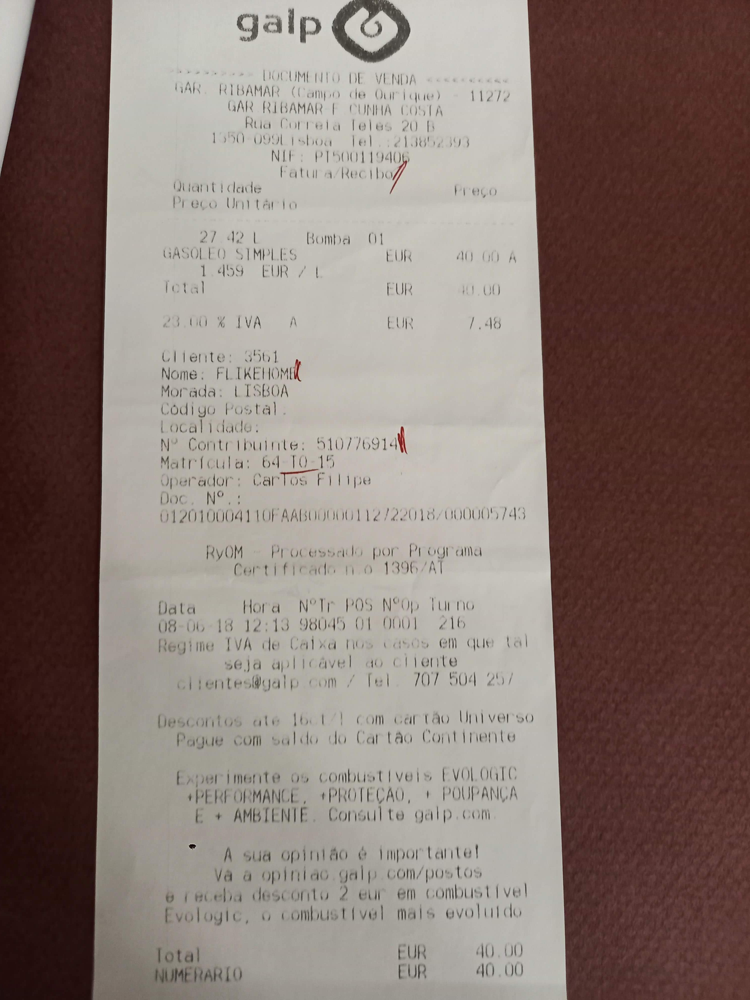

In [10]:
loaded_data[0]['image']

In [11]:
loaded_data[0]

{'question_id': 0,
 'is_train': True,
 'query': 'what is the company?',
 'answer': 'galp',
 'img_path': 'drive/MyDrive/Invoice_and_Receipts/1_Images/20210508_205607.jpg',
 'image': <PIL.Image.Image image mode=RGB size=750x1000>,
 'ground_truth': '{"gt_parse": [{"question" : "what is the company?", "answer" : "galp"}]}'}

In [12]:
# !pip install -q transformers


In [13]:
from transformers import DonutProcessor, VisionEncoderDecoderModel

processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")
# important: we need to pad from the left when doing batched inference
processor.tokenizer.padding_side = 'left'
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-docvqa")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [29]:
import re
import torch

# move model to GPU if it's available
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# prepare encoder inputs
pixel_values = processor(images=[x['image'] for x in loaded_data][0:2], return_tensors="pt").pixel_values
batch_size = pixel_values.shape

# prepare decoder inputs
task_prompt = "{user_input}"
questions = [x['query'] for x in loaded_data][0:2]
prompts = [task_prompt.replace("{user_input}", question) for question in questions]
decoder_input_ids = processor.tokenizer(prompts, add_special_tokens=False, padding=True, return_tensors="pt").input_ids

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    early_stopping=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=1,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

In [31]:
sequences = processor.batch_decode(outputs.sequences)

for seq in sequences:
  sequence = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
  sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
  print(processor.token2json(sequence))

{'text_sequence': 'what is the company? gallo coffee oilsmobiles eur'}
{'text_sequence': 'what is the date? 27 42 1 bombs 01 27 42 19195494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949494949'}


In [30]:
# seq = processor.batch_decode(outputs.sequences)[0]
# seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
# seq = re.sub(r"<.*?>", "", seq, count=1).strip()  # remove first task start token
# print(seq)

what is the company? gallo coffee oilsmobiles eur
